In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install tsgm

In [ ]:
! pip install mne

In [ ]:
! pip install BeautifulTable

In [ ]:
import numpy as np
import pandas as pd
import mne
import tsgm
import scipy.signal as signal
from scipy.signal import iirnotch, filtfilt
from scipy.signal import welch, butter, savgol_filter
from beautifultable import BeautifulTable
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

<ipython-input-95-68ae4913c410>:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab('/content/drive/MyDrive/signal_prc/16840351/10Abby_Resting.set', preload=True,verbose=False)
<ipython-input-95-68ae4913c410>:2: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab('/content/drive/MyDrive/signal_prc/16840351/10Abby_Resting.set', preload=True,verbose=False)


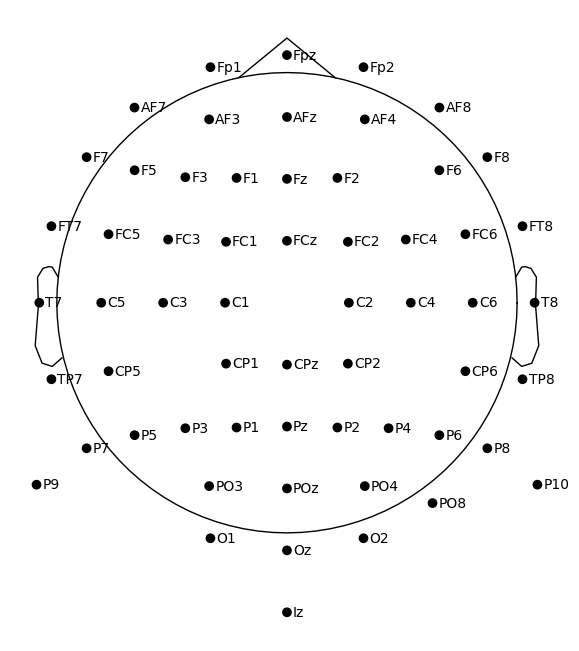

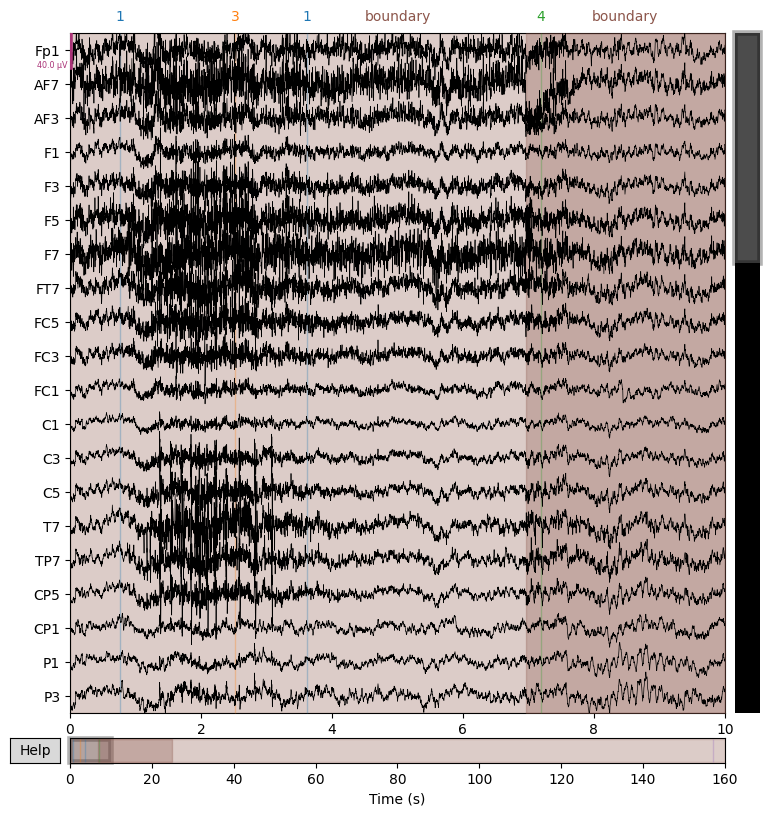

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1691 samples (3.303 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


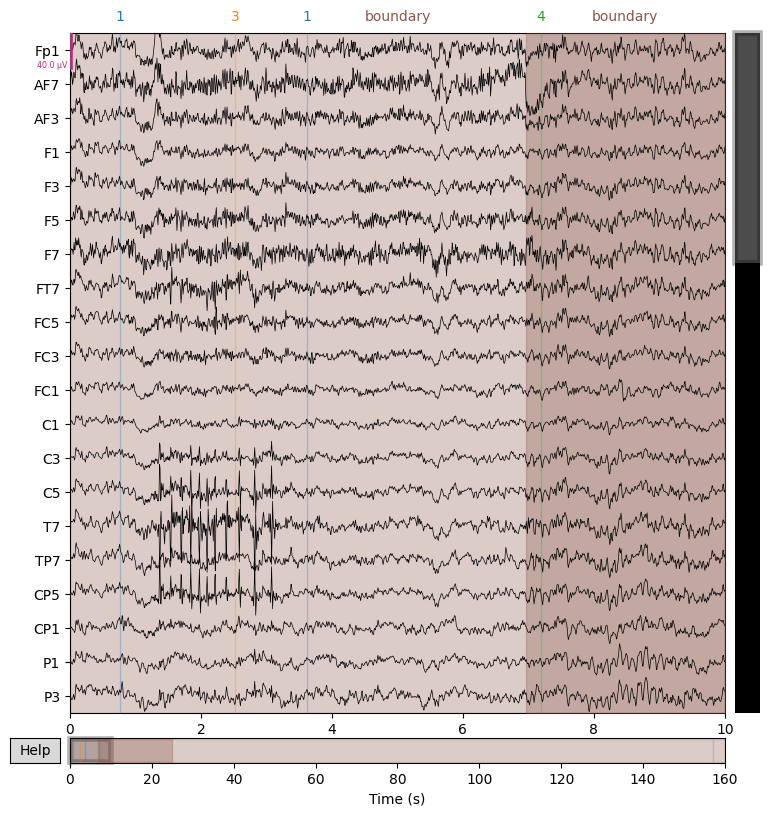

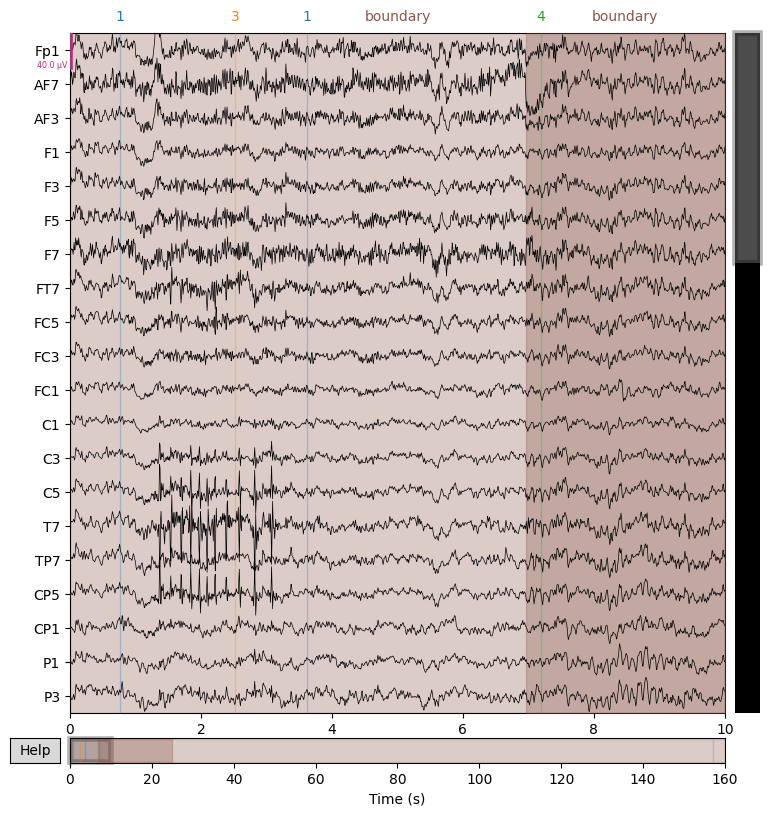

In [ ]:
# Plot one EEG Before and After Filter
raw = mne.io.read_raw_eeglab('/content/drive/10Abby_Resting.set', preload=True,verbose=False)
raw.plot_sensors(show_names=True)
plt.show()
# Plot raw data
raw.plot(title='Raw Data')
# Apply a band-pass filter
raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0)
# Plot filtered data
raw_filtered.plot(title='Filtered Data')

In [ ]:
# Function to apply a notch filter
def apply_notch_filter(data, sfreq, freqs, width):
    filtered_data = data.copy()
    for freq in freqs:
        b, a = iirnotch(freq, width, sfreq)
        for channel in range(filtered_data.shape[0]):
            filtered_data[channel, :] = filtfilt(b, a, data[channel, :])
    return filtered_data

In [ ]:
base_path = '/content/drive/Data_folder/'
file_prefix = 'Abby_Resting.set'
scaler = MinMaxScaler()

# Define parameters for windowing
window_size = 2  # Window size in seconds
overlap = 0.7    # Overlap between consecutive windows (70%)
all_mean_energies = []

# Loop over all EEG files
for i in range(1, 57):
    file_name = f"{base_path}{i}{file_prefix}"
    raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)

    filtered_data = raw.copy().filter(l_freq=40.0, h_freq=50.0)
    filtered_data = filtered_data.get_data()


    # Smooth the data using the Savitzky-Golay filter
    smooth_data = savgol_filter(filtered_data, window_length=31, polyorder=3, axis=1)

    # Normalize the data using min-max normalization
    normalized_data = scaler.fit_transform(smooth_data)

    # Apply a Hamming window to the EEG signal
    boxcar_window = signal.windows.boxcar(len(raw.times))
    windowed_data = normalized_data * boxcar_window  # Apply window to each channel

    # Calculate window length and step size
    sfreq = raw.info['sfreq']
    window_length = int(window_size * sfreq)
    step_size = int(window_length * (1 - overlap))

    mean_energies = []

    # Calculate energy for each window
    for j in range(0, windowed_data.shape[1] - window_length, step_size):
        # Extract a window of data
        window_data = windowed_data[:, j:j + window_length]

        window_energy = np.sum(window_data ** 2, axis=1)
        mean_window_energy = np.mean(window_energy)  # Mean energy

        # Append mean energy to list
        mean_energies.append(mean_window_energy)


    # Append mean energy array to the list
    all_mean_energies.append(mean_energies)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 6 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 40 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 40.00
- Lower transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 35.00 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 169 samples (0.330 s)



<ipython-input-97-22edccde1891>:17: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
<ipython-input-97-22edccde1891>:17: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(file_name, preload=True,verbose=False)
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


In [ ]:
AG_data = pd.DataFrame(all_mean_energies)
AG_data['label'] = 1
AG_data.loc[28:, 'label'] = 0
AG_data = np.array(AG_data)
X, Y = AG_data[:,:-1] , AG_data[:,-1]
X = np.nan_to_num(X, nan=0.0)  # Replace NaNs with 0
X.shape

(56, 264)

In [ ]:
scaler = MinMaxScaler()

X_train = []
X_test = []
y_train = []
y_test = []
FOLDS = 5
sss = StratifiedShuffleSplit(n_splits=FOLDS, test_size = 0.1, random_state=1)

for train, test in sss.split(X,Y):
    Fold_X_train, Fold_X_test = X[train], X[test]
    Fold_y_train, Fold_y_test = Y[train], Y[test]

    Fold_X_train = scaler.fit_transform(Fold_X_train)
    Fold_X_test = scaler.fit_transform(Fold_X_test)

    X_train.append(Fold_X_train)
    X_test.append(Fold_X_test)
    y_train.append(Fold_y_train)
    y_test.append(Fold_y_test)



In [ ]:
def return_augment_EEG(data_one, data_zero,fake_one,fake_zero):

    noisy_signal_one = data_one + fake_one
    noisy_signal_zero = data_zero + fake_zero
    extend_data = np.concatenate((noisy_signal_one,noisy_signal_zero))

    y_fake_one = np.ones(len(noisy_signal_one))
    y_fake_zero = np.zeros(len(noisy_signal_zero))
    y_fake = np.concatenate((y_fake_one,y_fake_zero))

    balanced_X = np.concatenate((X_train[i],extend_data))
    balanced_y = np.concatenate((y_train[i],y_fake))

    return balanced_X , balanced_y


In [ ]:
def Gaussian_Augmentation(data_one, data_zero):
    # Data Augmentation
    noise_one = np.random.normal(0, 0.1, size = data_one.shape)
    noise_zero = np.random.normal(0, 0.1, size = data_zero.shape)

    noisy_signal_one = data_one + noise_one
    noisy_signal_zero = data_zero + noise_zero
    extend_data = np.concatenate((noisy_signal_one,noisy_signal_zero))

    y_fake_one = np.ones(len(noisy_signal_one))
    y_fake_zero = np.zeros(len(noisy_signal_zero))
    y_fake = np.concatenate((y_fake_one,y_fake_zero))

    balanced_X = np.concatenate((X_train[i],extend_data))
    balanced_y = np.concatenate((y_train[i],y_fake))

    return balanced_X , balanced_y

In [ ]:
def shuffle_features(x, y):

    num_samples, num_features = x.shape
    x_shuffled = np.empty_like(x)

    for i in range(num_samples):
        shuffled_indices = np.random.permutation(num_features)
        x_shuffled[i] = x[i][shuffled_indices]

    # Labels remain unchanged
    y_shuffled = np.copy(y)

    balanced_X = np.concatenate((x,x_shuffled))
    balanced_y = np.concatenate([y,y_shuffled])
    return balanced_X , balanced_y


In [ ]:
def Shift_data(data_one, data_zero, max_shift=5):

    # Horizontal flip: switch I values to their opposites
    # Generate a random shift value within the specified range
    shift_amount = np.random.randint(-max_shift, max_shift + 1)
    # Perform the shift
    shifted_data_one = np.roll(data_one, shift_amount)
    shifted_data_zero = np.roll(data_zero, shift_amount)

    extend_data = np.concatenate((shifted_data_one,shifted_data_zero))

    y_fake_one = np.ones(len(shifted_data_one))
    y_fake_zero = np.zeros(len(shifted_data_zero))
    y_fake = np.concatenate((y_fake_one,y_fake_zero))

    balanced_X = np.concatenate((X_train[i],extend_data))
    balanced_y = np.concatenate([y_train[i],y_fake])

    return balanced_X , balanced_y



In [ ]:
def Slice_shuffle(data_one, data_zero):
    # Horizontal flip: switch I values to their opposites

    aug_model = tsgm.models.augmentations.SliceAndShuffle()
    samples_one = aug_model.generate(data_one, n_samples=len(data_one), n_segments=10)
    samples_zero = aug_model.generate(data_zero, n_samples=len(data_zero), n_segments=10)

    noisy_signal_one = data_one + samples_one
    noisy_signal_zero = data_zero + samples_zero
    extend_data = np.concatenate((noisy_signal_one,noisy_signal_zero))

    y_fake_one = np.ones(len(noisy_signal_one))
    y_fake_zero = np.zeros(len(noisy_signal_zero))
    y_fake = np.concatenate((y_fake_one,y_fake_zero))

    balanced_X = np.concatenate((X_train[i],extend_data))
    balanced_y = np.concatenate((y_train[i],y_fake))
    print(balanced_X.shape)
    print(balanced_y.shape)

    return balanced_X , balanced_y

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier

LR = LogisticRegression()
RF = RandomForestClassifier(random_state=0)
MLP = MLPClassifier(random_state=42, max_iter=3000)
SVM = SVC()
KNN = KNeighborsClassifier(n_neighbors=5)
DT = DecisionTreeClassifier(random_state=0)
models = [LR,RF,MLP,SVM,KNN,DT]

In [ ]:
# Function to calculate and print mean and std for 5-fold cross-validation
def print_clf_metrics(models, X_train_folds, y_train_folds, X_test_folds, y_test_folds, balanced_X, balanced_y):
    table = BeautifulTable(maxwidth=170)
    table.rows.header = ['LR', 'RF', 'MLP', 'SVM', 'KNN', 'DT']
    table.columns.header = ['ACC', 'blnc_ACC', 'Precision', 'blnc_Precision', 'Recall', 'blnc_Recall', 'f1_score', 'blnc_f1_score']

    metrics_results = {
        'ACC': [], 'blnc_ACC': [], 'Precision': [], 'blnc_Precision': [],
        'Recall': [], 'blnc_Recall': [], 'f1_score': [], 'blnc_f1_score': []
    }

    for i, model in enumerate(models):
        fold_results = {metric: [] for metric in metrics_results.keys()}

        for k in range(FOLDS):
            # Train on original data
            model.fit(X_train_folds[k], y_train_folds[k])
            ACC, Precision, Recall, f1 = return_metric(model, X_test_folds[k], y_test_folds[k])

            # Train on balanced data
            model.fit(balanced_X[k], balanced_y[k])
            blnc_ACC, blnc_Precision, blnc_Recall, blnc_f1score = return_metric(model, X_test_folds[k], y_test_folds[k])

            # Append results to fold_results
            fold_results['ACC'].append(ACC)
            fold_results['blnc_ACC'].append(blnc_ACC)
            fold_results['Precision'].append(Precision)
            fold_results['blnc_Precision'].append(blnc_Precision)
            fold_results['Recall'].append(Recall)
            fold_results['blnc_Recall'].append(blnc_Recall)
            fold_results['f1_score'].append(f1)
            fold_results['blnc_f1_score'].append(blnc_f1score)

        # Calculate mean and std for each metric
        for metric in metrics_results.keys():
            mean_value = np.mean(fold_results[metric])
            std_value = np.std(fold_results[metric])
            table.rows[i][list(metrics_results.keys()).index(metric)] = f"{mean_value:.2f} ± {std_value:.2f}"

    print(table)




In [ ]:
def return_metric(model,x_ , y_):

    y_pred = model.predict(x_)
    cnf_matrix = confusion_matrix(y_, y_pred)

    # Confusion Matrix
    cm = confusion_matrix(y_, y_pred)
    # Accuracy
    accuracy = accuracy_score(y_, y_pred)
    # Precision
    precision = precision_score(y_, y_pred, zero_division=1)
    # Recall
    recall = recall_score(y_, y_pred)
    # F1-Score
    f1 = f1_score(y_, y_pred)

    return  accuracy, precision, recall, f1

In [ ]:
GAUSSIAN_X = []
GAUSSIAN_Y = []

SHUFFLE_X = []
SHUFFLE_Y = []

SLICE_X = []
SLICE_Y = []

SHIFT_X = []
SHIFT_Y = []

FLIP_X = []
FLIP_Y = []

for i in range(FOLDS):
    gaussian_X , gaussian_Y = Gaussian_Augmentation(X_train[i][y_train[i]==1], X_train[i][y_train[i]==0])
    GAUSSIAN_X.append(gaussian_X)
    GAUSSIAN_Y.append(gaussian_Y)

    shuffle_X, shuffle_Y = shuffle_features(X_train[i], y_train[i])
    SHUFFLE_X.append(shuffle_X)
    SHUFFLE_Y.append(shuffle_Y)

    Slice_X, Slice_Y = Slice_shuffle(X_train[i][y_train[i]==1], X_train[i][y_train[i]==0])
    SLICE_X.append(Slice_X)
    SLICE_Y.append(Slice_Y)

    Shift_X, Shift_Y = Shift_data(X_train[i][y_train[i]==1], X_train[i][y_train[i]==0], max_shift=5)
    SHIFT_X.append(Shift_X)
    SHIFT_Y.append(Shift_Y)




(100, 264)
(100,)
(100, 264)
(100,)
(100, 264)
(100,)
(100, 264)
(100,)
(100, 264)
(100,)


In [ ]:
print('---------------------------------Gaussian_augmentation-------------------------------')
print_clf_metrics(models, X_train, y_train, X_test, y_test, GAUSSIAN_X, GAUSSIAN_Y)

---------------------------------Gaussian_augmentation-------------------------------
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
|     |     ACC     |  blnc_ACC   |  Precision  | blnc_Precision |   Recall    | blnc_Recall |  f1_score   | blnc_f1_score |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| LR  | 0.47 ± 0.12 | 0.50 ± 0.15 | 0.48 ± 0.07 |  0.50 ± 0.09   | 0.73 ± 0.13 | 0.80 ± 0.16 | 0.58 ± 0.09 |  0.61 ± 0.11  |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| RF  | 0.50 ± 0.11 | 0.50 ± 0.21 | 0.49 ± 0.09 |  0.58 ± 0.26   | 0.80 ± 0.27 | 0.60 ± 0.25 | 0.60 ± 0.14 |  0.54 ± 0.16  |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| MLP | 0.50 ± 0.18 | 0.47 ± 0.12 | 0.5

In [ ]:
print('------------------------------shuffle_augmentation----------------------------------')
print_clf_metrics(models, X_train, y_train, X_test, y_test, SHUFFLE_X, SHUFFLE_Y)

------------------------------shuffle_augmentation----------------------------------
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
|     |     ACC     |  blnc_ACC   |  Precision  | blnc_Precision |   Recall    | blnc_Recall |  f1_score   | blnc_f1_score |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| LR  | 0.47 ± 0.12 | 0.67 ± 0.15 | 0.48 ± 0.07 |  0.73 ± 0.23   | 0.73 ± 0.13 | 0.60 ± 0.13 | 0.58 ± 0.09 |  0.65 ± 0.15  |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| RF  | 0.50 ± 0.11 | 0.70 ± 0.22 | 0.49 ± 0.09 |  0.74 ± 0.25   | 0.80 ± 0.27 | 0.73 ± 0.33 | 0.60 ± 0.14 |  0.69 ± 0.24  |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| MLP | 0.50 ± 0.18 | 0.53 ± 0.19 | 0.50

In [ ]:
print('------------------------------slice_Shuffle_augmentation-----------------------------')
print_clf_metrics(models, X_train, y_train, X_test, y_test, SLICE_X, SLICE_Y)

------------------------------slice_Shuffle_augmentation-----------------------------
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
|     |     ACC     |  blnc_ACC   |  Precision  | blnc_Precision |   Recall    | blnc_Recall |  f1_score   | blnc_f1_score |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| LR  | 0.47 ± 0.12 | 0.47 ± 0.16 | 0.48 ± 0.07 |  0.48 ± 0.13   | 0.73 ± 0.13 | 0.60 ± 0.13 | 0.58 ± 0.09 |  0.53 ± 0.13  |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| RF  | 0.50 ± 0.11 | 0.53 ± 0.07 | 0.49 ± 0.09 |  0.53 ± 0.07   | 0.80 ± 0.27 | 0.60 ± 0.25 | 0.60 ± 0.14 |  0.54 ± 0.12  |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| MLP | 0.50 ± 0.18 | 0.50 ± 0.11 | 0.5

In [ ]:
print('----------------------------------Shift_augmentation---------------------------------')
print_clf_metrics(models, X_train, y_train, X_test, y_test, SHIFT_X, SHIFT_Y)

----------------------------------Shift_augmentation---------------------------------
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
|     |     ACC     |  blnc_ACC   |  Precision  | blnc_Precision |   Recall    | blnc_Recall |  f1_score   | blnc_f1_score |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| LR  | 0.47 ± 0.12 | 0.50 ± 0.15 | 0.48 ± 0.07 |  0.50 ± 0.09   | 0.73 ± 0.13 | 0.80 ± 0.16 | 0.58 ± 0.09 |  0.61 ± 0.11  |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| RF  | 0.50 ± 0.11 | 0.37 ± 0.19 | 0.49 ± 0.09 |  0.41 ± 0.16   | 0.80 ± 0.27 | 0.60 ± 0.25 | 0.60 ± 0.14 |  0.48 ± 0.17  |
+-----+-------------+-------------+-------------+----------------+-------------+-------------+-------------+---------------+
| MLP | 0.50 ± 0.18 | 0.53 ± 0.16 | 0.5